In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
train_set = torchvision.datasets.FashionMNIST('./data', download=True, transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [19]:
#train_loader, test_loader 불러오기
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100)


In [20]:
#데이터셋에 대한 라벨링
def output_label(label):
    output_mapping = {0:'T-shirt/Top',
                      1:'Trouser',
                      2:'Pullover',
                      3:'Dress',
                      4:'Coat',
                      5:'Sandal',
                      6:'Shirt',
                      7:'Sneaker',
                      8:'Bag',
                      9:'Ankle Boot'}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [21]:
a=next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [22]:
len(train_set)

60000

In [23]:
len(test_set)

10000

9


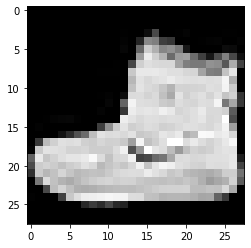

In [24]:
#데이터셋이 어떤 데이터셋을 가지고 있는지 시각화, matplotlib 사용
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap='gray')
print(label)

In [35]:
#CNN 모델 구성
class CNN(nn.Module):   
    def __init__(self):   
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
                                    nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        
        self.fc1 = nn.Linear(in_features=6*6*64, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self,x):   
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
        
        

In [36]:
#모델 구조 파악
model = CNN()
model.to(device)   #GPU연산이 가능하도록 to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [38]:
#training

num_epochs = 15
count = 0

#실행에 필요한 loss, iteration, accuracy 시각화를 위해 list형태로 초기화
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

#epoch만큼 반복훈련 실행
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = error(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        count+=1
        
        if not (count%50):
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100,1,28,28))
                
                outputs = model(test)
                
                predictions = torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                
                total += len(labels)
                
            accuracy = correct * 100/ total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print('Iteration:{}, Loss:{}, Accuracy:{}%'.format(count, loss.data, accuracy))

Iteration:500, Loss:2.366424798965454, Accuracy:11.420000076293945%
Iteration:1000, Loss:2.3092801570892334, Accuracy:10.670000076293945%
Iteration:1500, Loss:2.291337251663208, Accuracy:11.210000038146973%
Iteration:2000, Loss:2.278810501098633, Accuracy:11.15999984741211%
Iteration:2500, Loss:2.285735845565796, Accuracy:10.670000076293945%
Iteration:3000, Loss:2.3055238723754883, Accuracy:11.359999656677246%
Iteration:3500, Loss:2.377255916595459, Accuracy:11.079999923706055%
Iteration:4000, Loss:2.3361663818359375, Accuracy:11.15999984741211%
Iteration:4500, Loss:2.2670228481292725, Accuracy:11.15999984741211%
Iteration:5000, Loss:2.2701921463012695, Accuracy:11.300000190734863%
Iteration:5500, Loss:2.3063533306121826, Accuracy:10.75999927520752%
Iteration:6000, Loss:2.3039722442626953, Accuracy:11.729999542236328%
Iteration:6500, Loss:2.3619463443756104, Accuracy:11.1899995803833%
Iteration:7000, Loss:2.321225643157959, Accuracy:11.170000076293945%
Iteration:7500, Loss:2.2609343528

In [39]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs,1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
for i in range(10):
    print('Accuracy of {} : {:.2f}%'.format(output_label(i), class_correct[i]*100/total_correct[i]))

Accuracy of T-shirt/Top : 0.00%
Accuracy of Trouser : 32.60%
Accuracy of Pullover : 8.40%
Accuracy of Dress : 26.60%
Accuracy of Coat : 21.40%
Accuracy of Sandal : 0.20%
Accuracy of Shirt : 0.00%
Accuracy of Sneaker : 2.10%
Accuracy of Bag : 21.50%
Accuracy of Ankle Boot : 0.00%
